# Sentiment Analysis
----
Latihan Sentimen Analysis dari data event GDELT. Data yang diambil adalah pemberitaan ekonomi terkait dengan Indonesia dari beberapa media bisnis dan ekonomi global periode Januari 2016-Agustus 2018 antara lain:
1. www.economics.com
2. www.businesstimes.com
3. www.econotimes.com
4. www.eco-business.com
5. www.aseaneconomist.com
6. www.businessinsider.com
7. www.jakartaglobe.id/economy
8. www.businesswire.com
9. www.wsj.com/news/economy
10. www.reuters.com/news/archive/economicNews
11. www.money.cnn.com/news/economy/
12. www.theguardian.com/business/economics
13. www.marketwatch.com/economy-politics
14. www.nbcnews.com/business/economy
15. www.globalnews.ca/economy/
16. www.straitstimes.com/business/economy
17. www.bloombergquint.com/global-economics 

Jumlah artikel berita yang digunakan sebagai sumber data kurang lebih sejumlah 1200 berita dan seluruhnya berbahasa Inggris.

## Inisiasi Library

In [1]:
import pandas as pd
import sys
from IPython.display import clear_output
import os

## Build Corpus

In [2]:
# bisa langsung diskip jika sudah punya file corpusnya (corpus-economics.pkl)
def get_sentiment(avgTone):
    s = float(avgTone)
    print(s)
    if (s >= 1):
        return 1
    elif (s <= -1):
        return -1
    else:
        return 0
  

In [3]:
# bisa langsung diskip jika sudah punya file corpusnya
news = pd.read_csv('economics2015-2018.csv')
corpus = []
i = 0

for subdir, dirs, files in os.walk('./news/'):
    for file in files:
        filepath = file

        if filepath.endswith(".txt"):
            global_id = filepath[:-4]
            currentRow = news[news['GLOBALEVENTID'] == int(global_id)];
            
            if len(currentRow > 0):            
                with open("./news/"+filepath,"r", encoding='UTF-8') as f:
                    text = f.read()
                    
                    sentiment = get_sentiment(currentRow['AvgTone'])                      
                    corpus.append({'text': text ,'sentiment': sentiment, 'url': currentRow['SOURCEURL'], 'EventID': global_id, 'AvgTone': currentRow['AvgTone'].values[0]})
                    i += 1
                    print('Added :',i, '->', sentiment)

            if (i % 10 == 0):
                clear_output(wait=True)            
            

-2.65258569517413
Added : 1611 -> -1
-2.98507462686567
Added : 1612 -> -1
-3.0378198132645
Added : 1613 -> -1
-4.47461669814611
Added : 1614 -> -1
-0.18484288354898
Added : 1615 -> 0
0.9107468123861601
Added : 1616 -> 0
1.33122346972094
Added : 1617 -> 1
-5.978074683110651
Added : 1618 -> -1
-4.04040404040404
Added : 1619 -> -1
-1.9047619047619
Added : 1620 -> -1


In [ ]:
df_corpus = pd.DataFrame(corpus)
df_corpus.to_pickle('economics.corpus')

In [ ]:
df_corpus.groupby('sentiment').count()

## Data Preparation

In [4]:
from sklearn.model_selection import train_test_split
import numpy as np

df_corpus = pd.read_pickle('corpus/economics.corpus')
# df_corpus = pd.read_pickle('corpus-economics3.pkl')

# df_corpus = df_corpus.sort_values('AvgTone', ascending=True).groupby('sentiment').head(250)

X = df_corpus.text
y = df_corpus.sentiment

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= 42)



In [5]:
y_train.value_counts()

-1    545
 1    210
 0    210
Name: sentiment, dtype: int64

In [6]:
#tokenisasi, stemming dsb

from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer 
from nltk.stem.snowball import SnowballStemmer
import nltk
from sklearn.metrics.pairwise import cosine_similarity

import re

porter_stemmer = PorterStemmer()
stemmer = SnowballStemmer("english")

def custom_tokenizer(str_input):
    words = re.sub(r"[^a-z]|\b\w{0,3}\b", " ", str_input).lower().split()
    words = [WordNetLemmatizer().lemmatize(word) for word in words]
    words = [stemmer.stem(word) for word in words]    
    return words
   
def get_similarity_matrix(content_as_str):
    tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000, min_df=0.2,
                                       stop_words='english',use_idf=True,
                                       tokenizer=tokenize_and_stem, ngram_range=(1,3))
    tfidf_matrix = tfidf_vectorizer.fit_transform(content_as_str) #fit the vectorizer to synopses
    similarity_matrix = cosine_similarity(tfidf_matrix)
    return (similarity_matrix, tfidf_matrix)

def display_scores(vectorizer, tfidf_result):    
    scores = zip(vectorizer.get_feature_names(),
                 np.asarray(tfidf_result.sum(axis=0)).ravel())
    sorted_scores = sorted(scores, key=lambda x: x[1], reverse=True)
    for item in sorted_scores:
        print("{0:50} Score: {1}".format(item[0], item[1]))

In [9]:
# ekstraksi fitur

from sklearn.feature_extraction.text import TfidfVectorizer  
from sklearn.feature_extraction import text

my_stop_words = text.ENGLISH_STOP_WORDS.union(["january","february","march",'april','may','june','july','august','september','october','november','december'])
my_stop_words = my_stop_words.union(["jakarta","jokowi",'said','says','just','mr',
                                               "widodo","joko",'singapore','www','http','https',
                                               'indonesia','indonesians','bali','rupiah',
                                               'indonesian','thailand','china', 'asia', 'asian',
                                               'vietnam','australian','australia', 'sentifi', 'york','s','java','chinese',
                                               'india','malaysia','hong','used'])

my_stop_words = my_stop_words.union(["sunday","monday","tuesday",'thursday','wednesday','friday','year','years'
                                     'days','week','weeks','day','date','time'])

# 
vectorizer = TfidfVectorizer(analyzer=u'word', smooth_idf=True, sublinear_tf=True, tokenizer=custom_tokenizer, ngram_range=(1,4), stop_words=my_stop_words, min_df=0.05, max_df=0.7, lowercase=True)
X = vectorizer.fit_transform(X_train)

X_train_dtm = vectorizer.transform(X_train)

X_dtm = vectorizer.transform(df_corpus.text)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:286: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'chines', 'decemb', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'februari', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'januari', 'juli', 'le', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'novemb', 'nowher', 'octob', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'say', 'septemb', 'sever', 'sinc', 'sincer', 'singapor', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'use', 'veri', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'yearsday', 'yourselv'

In [10]:
df_corpus['matrix'] = X_dtm

In [14]:
print(df_corpus['matrix'][1])

  (0, 878)	0.0539211639304718
  (0, 876)	0.03647128820269211
  (0, 875)	0.06520533145380704
  (0, 869)	0.06520533145380704
  (0, 867)	0.06862869605367586
  (0, 863)	0.0918957267567631
  (0, 860)	0.15104242392211017
  (0, 848)	0.038991248402246256
  (0, 844)	0.06084708382568403
  (0, 843)	0.04402613670943605
  (0, 838)	0.09914484197107903
  (0, 837)	0.06064461621419102
  (0, 835)	0.29087393967521197
  (0, 829)	0.17922877437978918
  (0, 823)	0.04677497051460532
  (0, 813)	0.059207467439725284
  (0, 807)	0.11930349502770952
  (0, 804)	0.09824808295238127
  (0, 803)	0.06801076609610283
  (0, 783)	0.06189523014490345
  (0, 768)	0.0895940703319736
  (0, 763)	0.09369362746156266
  (0, 760)	0.06494751127957386
  (0, 752)	0.06712207853414304
  (0, 746)	0.06959748295764238
  :	:
  (1206, 311)	0.10180108424277673
  (1206, 310)	0.1568664663951188
  (1206, 302)	0.11298326565620703
  (1206, 299)	0.10298151106274471
  (1206, 292)	0.0750556666327363
  (1206, 275)	0.15149499278415252
  (1206, 255)	0.12

In [712]:
# menampilkan skor kata, bisa diskip
# len(vectorizer.get_feature_names())
# display_scores(vectorizer, X_train_dtm)

from nltk.tokenize import word_tokenize, RegexpTokenizer

tokenizer = RegexpTokenizer(r'\w+')
stop_words = text.ENGLISH_STOP_WORDS.union('s')

def process_text(headlines):
    tokens = []
    for line in headlines:
        toks = tokenizer.tokenize(line)
        toks = [t.lower() for t in toks if t.lower() not in stop_words]
        tokens.extend(toks)
    
    return tokens


pos_lines = list(df_corpus[df_corpus.sentiment >= -1].text)

pos_tokens = process_text(pos_lines)
pos_freq = nltk.FreqDist(pos_tokens)

pos_freq.most_common(400)


[('indonesia', 4820),
 ('said', 4771),
 ('year', 1729),
 ('indonesian', 1712),
 ('oil', 1710),
 ('government', 1570),
 ('palm', 1398),
 ('company', 1356),
 ('market', 1339),
 ('new', 1252),
 ('jakarta', 1228),
 ('people', 1206),
 ('cent', 1189),
 ('singapore', 1161),
 ('world', 1127),
 ('million', 1108),
 ('business', 1055),
 ('country', 1036),
 ('1', 1029),
 ('companies', 1021),
 ('asia', 988),
 ('years', 913),
 ('group', 877),
 ('land', 841),
 ('china', 817),
 ('t', 807),
 ('mr', 796),
 ('president', 773),
 ('told', 772),
 ('000', 761),
 ('global', 748),
 ('2', 745),
 ('forest', 741),
 ('local', 734),
 ('time', 719),
 ('5', 718),
 ('countries', 711),
 ('according', 708),
 ('energy', 699),
 ('billion', 695),
 ('industry', 691),
 ('com', 676),
 ('international', 672),
 ('state', 665),
 ('including', 655),
 ('like', 635),
 ('development', 633),
 ('coal', 628),
 ('report', 605),
 ('says', 599),
 ('reuters', 597),
 ('3', 594),
 ('ministry', 589),
 ('south', 589),
 ('police', 584),
 ('pt',

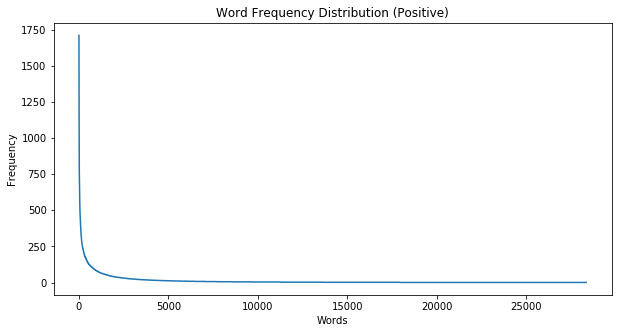

In [695]:
import matplotlib.pyplot as plt

y_val = [x[1] for x in pos_freq.most_common()]

fig = plt.figure(figsize=(10,5))
plt.plot(y_val)

plt.xlabel("Words")
plt.ylabel("Frequency")
plt.title("Word Frequency Distribution (Positive)")
plt.show()


In [533]:
# menampilkan data transformation matrix, bisa diskip

pd.DataFrame(X_train_dtm.toarray(), columns=vectorizer.get_feature_names()).sample(10)

,abl,abov,accept,access,accord,account,accus,achiev,act,action,...,wit,woman,work,worker,world,worst,worth,write,young,zone
573,0.023498,0.0,0.0,0.023127,0.067197,0.0,0.0,0.000000,0.000000,0.052117,...,0.0,0.0,0.082013,0.0,0.055616,0.000000,0.0,0.00000,0.0,0.0
223,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.00000,0.0,0.0
596,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.024433,0.000000,0.000000,...,0.0,0.0,0.015837,0.0,0.040272,0.029714,0.0,0.02702,0.0,0.0
407,0.000000,0.0,0.0,0.031454,0.000000,0.0,0.0,0.000000,0.042527,0.000000,...,0.0,0.0,0.022308,0.0,0.094550,0.000000,0.0,0.00000,0.0,0.0
560,0.000000,0.0,0.0,0.000000,0.053173,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.00000,0.0,0.0
260,0.000000,0.0,0.0,0.031454,0.000000,0.0,0.0,0.000000,0.042527,0.000000,...,0.0,0.0,0.022308,0.0,0.094550,0.000000,0.0,0.00000,0.0,0.0
199,0.000000,0.0,0.0,0.000000,0.027039,0.0,0.0,0.000000,0.000000,0.041943,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.00000,0.0,0.0
262,0.000000,0.0,0.0,0.000000,0.071460,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.069773,0.0,0.000000,0.000000,0.0,0.00000,0.0,0.0
391,0.000000,0.0,0.0,0.037653,0.000000,0.0,0.0,0.041202,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.045275,0.000000,0.0,0.00000,0.0,0.0
65,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.00000,0.0,0.0


# Classification Using Naive Bayes
----

## 1. Training

In [759]:
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
nb = MultinomialNB(alpha=0.2)

In [760]:
%time nb.fit(X_train_dtm, y_train)

CPU times: user 3.86 ms, sys: 0 ns, total: 3.86 ms
Wall time: 5.21 ms


MultinomialNB(alpha=0.2, class_prior=None, fit_prior=True)

## 2. Test

In [761]:
X_test_dtm = vectorizer.transform(X_test)

y_pred_class = nb.predict(X_test_dtm)


In [762]:
from sklearn import metrics
metrics.accuracy_score(y_test, y_pred_class)

0.8140495867768595

In [763]:
metrics.confusion_matrix(y_test, y_pred_class)

array([[151,   6,   1],
       [ 17,  13,   9],
       [  6,   6,  33]])

In [764]:
prediction = nb.predict(X_test_dtm)

test_df = pd.DataFrame(
    {'text': X_test,
     'sentiment': y_test,     
     'prediction': prediction,
    })

test_df['correct'] = test_df['sentiment'] == test_df['prediction']

In [765]:
test_df

,text,sentiment,prediction,correct
101,"BENSALEM, Pa.--(BUSINESS WIRE)--Law Offices of...",-1,-1,True
260,Dutch national pension fund APB is divesting 3...,-1,-1,True
1083,Indonesia expects to sign an initial deal on S...,-1,-1,True
109,JAKARTA (Reuters) - Indonesia's foreign minist...,-1,-1,True
649,"* Pence calls Indonesia Islam ""an inspiration""...",0,-1,False
736,Shutterstock/Netfalls Remy Musser For a billio...,1,1,True
332,When the earthquake and tsunami hit the city o...,-1,-1,True
49,When Southeast Asia was hit by the worst haze ...,-1,-1,True
461,"Under the Trump administration, the U.S. comme...",-1,-1,True
921,By Beh Lih Yi\n\nJAKARTA (Thomson Reuters Foun...,-1,-1,True


In [687]:
from sklearn.model_selection import cross_validate

X_dtm = vectorizer.transform(df_corpus.text)

cv_results = cross_validate(nb, X_dtm, y, cv=5,
                            return_train_score=False)
sorted(cv_results.keys())                         

cv_results

{'fit_time': array([0.00360775, 0.00363064, 0.00359321, 0.0036881 , 0.00357699]),
 'score_time': array([0.00052857, 0.00051951, 0.00055003, 0.00061345, 0.00051618]),
 'test_score': array([0.72727273, 0.72727273, 0.75206612, 0.74273859, 0.70416667])}

In [688]:
np.mean(cv_results['test_score'])

0.7307033652252437

In [568]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=42)
kf.get_n_splits(df_corpus)
accuracy = []
for train_index, test_index in kf.split(df_corpus):   
    X_train, X_test = df_corpus.text[train_index], df_corpus.text[test_index]
    y_train, y_test = df_corpus.sentiment[train_index], df_corpus.sentiment[test_index]
    
    
    X = vectorizer.fit_transform(X_train)
    X_train_dtm = vectorizer.transform(X_train)
    
    nb.fit(X_train_dtm, y_train)    
    X_test_dtm = vectorizer.transform(X_test)   
    y_pred_class = nb.predict(X_test_dtm)
    score = metrics.accuracy_score(y_test, y_pred_class)
    
    accuracy.append(score)

print(accuracy)
print(np.mean(accuracy))

[0.8057851239669421, 0.7396694214876033, 0.7012448132780082, 0.7178423236514523, 0.6597510373443983]
0.7248585439456808


# Classification Using SVM
----

## 1. Training

In [719]:
from sklearn import svm
from sklearn.metrics import accuracy_score

clf = svm.SVC(kernel='linear')
print("Training Classifier...")
%time clf.fit(X_train_dtm, y_train)

Training Classifier...
CPU times: user 991 ms, sys: 20 ms, total: 1.01 s
Wall time: 819 ms


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

## 2. Test

In [720]:
# prediction
prediction = clf.predict(X_test_dtm)

test_df = pd.DataFrame(
    {'text': X_test,
     'sentiment': y_test,     
     'prediction': prediction,
    })

test_df['correct'] = test_df['sentiment'] == test_df['prediction']

y_pred_class = clf.predict(X_test_dtm)

ValueError: X.shape[1] = 886 should be equal to 885, the number of features at training time

In [523]:
from sklearn import metrics
metrics.accuracy_score(y_test, y_pred_class)

0.75

In [524]:
metrics.confusion_matrix(y_test, y_pred_class)

array([[40,  3,  0],
       [ 5, 21, 10],
       [ 1, 11, 29]])

In [525]:
test_df

,text,sentiment,prediction,correct
478,MANILA (Reuters) - Philippine security forces ...,-1,-1,True
74,"The revised Trans-Pacific Partnership (TPP), i...",1,0,False
658,There are specific sectors that the two countr...,1,1,True
505,Nearly two dozen people have been killed and d...,-1,-1,True
99,The rate of deforestation in selective-logging...,-1,-1,True
379,BLACKGOLD subsidiary PT Samantaka Batubara’s p...,0,0,True
284,The UK government is investigating claims of i...,-1,-1,True
889,"Additional 7,500 hectares of smallholder land ...",1,0,False
895,This article is part of the Democracy Futures ...,-1,-1,True
1070,Rising oil prices have put Indonesian fuel cos...,0,0,True


In [526]:
from sklearn.model_selection import cross_validate

X_dtm = vectorizer.transform(df_corpus.text)

cv_results = cross_validate(clf, X_dtm, y, cv=5,
                            return_train_score=False)
sorted(cv_results.keys())                         

cv_results

{'fit_time': array([0.20360422, 0.20734811, 0.1996367 , 0.20903826, 0.19578004]),
 'score_time': array([0.04242468, 0.04387188, 0.0460825 , 0.04127312, 0.04535174]),
 'test_score': array([0.70833333, 0.70833333, 0.65      , 0.76666667, 0.70833333])}

In [527]:
np.mean(cv_results['test_score'])

0.7083333333333334